<a href="https://colab.research.google.com/github/silviolima07/animaeduca/blob/main/Anima_Enem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo: gerar um modelo de regressão para prever a media ponderada.
## Tratamentos e procedimentos efetuados:
- identificar e remover colunas com valores unicos
- identificar e remover colunas com mais 50% de dados ausentes
- identificar a quantidade de notas ausentes entre as 5 notas usadas no calculo da media ponderada por aluno
- remover as linhas onde faltam as 5 notas do aluno
- remover outliers nas colunas de notas
- imputar as notas ausentes pela mediana das notas existentes por aluno
- atribuir os pesos as notas dos alunos
- calcular a media_ponderada e criar uma nova coluna
- dividir as colunas do dataset em df_object e df_number
- checar dados ausentes em df_object e df_number
- checar colunas com valores unicos e com muitos valores
- converter colunas objeto em numerico
- criar grupos em colunas com muitos valores
- criar um dataset unico com df_object e df_number tratados
- checar a correlacao das variaveis com a media ponderada
- criar um dataset df_60 com as 60 variaveis com maior correlacao com a media ponderada
- criar um dataset df_30 com as 30 variaveis com maior correlacao com a media ponderada
- gerar um baseline para comparacao
- treinar e avaliar tres modelos usando 3 algoritmos de regressao
- identificar o melhor pela metrica mean absolute error (mae)
- identificar com shap value as variaveis que mais impactam na previsao da media ponderada.


In [ ]:
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from IPython.core.pylabtools import figsize
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Seu dataframe tem " + str(df.shape[1]) + " colunas.\n"      
            "Há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que possuem valores ausentes.")
        
        return mis_val_table_ren_columns

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
def fit_and_evaluate(model):
    
    model.fit(X, y)
    
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [ ]:
def sum_and_plot_importances(variables, importances):
    sum_importances = pd.DataFrame()
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        sum_importances = sum_importances.append(this_variable, ignore_index = True)
    plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
    return sum_importances 

In [ ]:
def plot_models(knn_mae, gradient_boosted_mae, random_forest_mae):
    plt.style.use('fivethirtyeight')
    figsize(8, 8)


    model_comparison = pd.DataFrame({'model': [
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

    model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

    plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
    plt.title('Comparação dos Modelos nos Dados de Teste Usando MAE', size = 20);

In [ ]:
def plot_models2(df_mae):
    plt.style.use('fivethirtyeight')
    figsize(15, 20)

    
    sns.catplot(x='Modelo', y='Mae', hue='Total_features', kind='bar', data=df_mae)

    plt.ylabel('Mean Absolute Error'); plt.yticks(size = 12); plt.xlabel(''); plt.xticks(size = 10)
    plt.title('Comparação dos Modelos nos Dados de Teste Usando MAE', size = 20);

In [ ]:
def aplicar_padronizacao(X, X_test, y, y_test):
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler.fit(X)

    X = scaler.transform(X)
    X_test = scaler.transform(X_test)

    #
    y = np.array(y).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))

    return (X, X_test, y, y_test)

In [ ]:
df_dados = pd.read_csv('/content/drive/MyDrive/DATASETS/dado_mg.csv', sep=';')

In [ ]:
df_dados

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001237802,2019,3118601,Contagem,31,MG,22.0,F,1,1,...,B,A,A,B,A,A,C,B,B,B
1,190001237803,2019,3170206,Uberlândia,31,MG,30.0,F,1,2,...,A,A,A,B,A,A,B,A,A,A
2,190001237804,2019,3124104,Esmeraldas,31,MG,27.0,M,1,3,...,A,A,A,B,A,B,C,A,A,A
3,190001237805,2019,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,...,B,A,B,C,B,A,E,A,B,B
4,190001237806,2019,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,...,B,A,A,B,B,A,C,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534622,190005766803,2019,3171204,Vespasiano,31,MG,23.0,M,1,2,...,B,A,A,C,A,B,D,A,B,B
534623,190005766804,2019,3170206,Uberlândia,31,MG,28.0,F,2,1,...,A,A,B,B,B,B,C,B,B,B
534624,190005766805,2019,3162500,São João del Rei,31,MG,20.0,M,1,4,...,B,A,B,C,B,B,C,B,B,B
534625,190005766806,2019,3158201,Santa Maria do Suaçuí,31,MG,18.0,F,1,3,...,A,A,A,B,A,A,B,A,A,A


## Identificar colunas com valores únicos.
## Colunas que apresentam os mesmos valores não auxiliam na criação de um modelo de machine.

In [ ]:
colunas = df_dados.columns

In [ ]:
colunas

Index(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'],
      dtype='object', length=136)

In [ ]:
cols = []
print("Coluna e quantidade de itens diferentes\n")
for col in colunas:
    teste = list(df_dados[col].value_counts())
    size = len(teste)
    print(col, ':',size)
    if size == 1:
      cols.append(col)
print("\nTotal de colunas com valores unicos:", len(cols))       

Coluna e quantidade de itens diferentes

NU_INSCRICAO : 534627
NU_ANO : 1
CO_MUNICIPIO_RESIDENCIA : 1490
NO_MUNICIPIO_RESIDENCIA : 1483
CO_UF_RESIDENCIA : 26
SG_UF_RESIDENCIA : 26
NU_IDADE : 73
TP_SEXO : 2
TP_ESTADO_CIVIL : 5
TP_COR_RACA : 6
TP_NACIONALIDADE : 5
CO_MUNICIPIO_NASCIMENTO : 3166
NO_MUNICIPIO_NASCIMENTO : 3083
CO_UF_NASCIMENTO : 27
SG_UF_NASCIMENTO : 27
TP_ST_CONCLUSAO : 4
TP_ANO_CONCLUIU : 14
TP_ESCOLA : 3
TP_ENSINO : 2
IN_TREINEIRO : 2
CO_ESCOLA : 3510
CO_MUNICIPIO_ESC : 996
NO_MUNICIPIO_ESC : 994
CO_UF_ESC : 22
SG_UF_ESC : 22
TP_DEPENDENCIA_ADM_ESC : 4
TP_LOCALIZACAO_ESC : 2
TP_SIT_FUNC_ESC : 4
IN_BAIXA_VISAO : 2
IN_CEGUEIRA : 2
IN_SURDEZ : 2
IN_DEFICIENCIA_AUDITIVA : 2
IN_SURDO_CEGUEIRA : 2
IN_DEFICIENCIA_FISICA : 2
IN_DEFICIENCIA_MENTAL : 2
IN_DEFICIT_ATENCAO : 2
IN_DISLEXIA : 2
IN_DISCALCULIA : 2
IN_AUTISMO : 2
IN_VISAO_MONOCULAR : 2
IN_OUTRA_DEF : 2
IN_GESTANTE : 2
IN_LACTANTE : 2
IN_IDOSO : 2
IN_ESTUDA_CLASSE_HOSPITALAR : 1
IN_SEM_RECURSO : 2
IN_BRAILLE : 2
IN_AMPL

In [ ]:
df_dados[cols]

,NU_ANO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_GUIA_INTERPRETE,IN_PROVA_DEITADO,IN_MARCA_PASSO,CO_UF_PROVA,SG_UF_PROVA
0,2019,0,0,0,0,31,MG
1,2019,0,0,0,0,31,MG
2,2019,0,0,0,0,31,MG
3,2019,0,0,0,0,31,MG
4,2019,0,0,0,0,31,MG
...,...,...,...,...,...,...,...
534622,2019,0,0,0,0,31,MG
534623,2019,0,0,0,0,31,MG
534624,2019,0,0,0,0,31,MG
534625,2019,0,0,0,0,31,MG


## Essas colunas são removidas do dataset

In [ ]:
df_dados2 = df_dados.drop(columns = list(cols))
df_dados2.shape

(534627, 129)

## Identificar colunas com dados ausentes e percentual em relacao ao total de linhas do dataset.
## Colunas com % Total Values acima de 50% serão removidas.

In [ ]:
missing_values_table(df_dados2)

Seu dataframe tem 129 colunas.
Há 37 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
TP_LOCALIZACAO_ESC,427013,79.9
CO_ESCOLA,427013,79.9
CO_MUNICIPIO_ESC,427013,79.9
NO_MUNICIPIO_ESC,427013,79.9
CO_UF_ESC,427013,79.9
SG_UF_ESC,427013,79.9
TP_DEPENDENCIA_ADM_ESC,427013,79.9
TP_SIT_FUNC_ESC,427013,79.9
TP_ENSINO,246259,46.1
CO_PROVA_CN,143772,26.9


In [ ]:
# Obtenha as colunas com > 50% de valores missing
missing_df = missing_values_table(df_dados2);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('Vamos remover %d colunas pois apresentam um percentual alto de  valores ausentes.' % len(missing_columns))

Seu dataframe tem 129 colunas.
Há 37 colunas que possuem valores ausentes.
Vamos remover 8 colunas pois apresentam um percentual alto de  valores ausentes.


In [ ]:
df_dados3 = df_dados2.drop(columns = list(missing_columns))
df_dados3.shape

(534627, 121)

In [ ]:
df_dados3

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001237802,3118601,Contagem,31,MG,22.0,F,1,1,1,...,B,A,A,B,A,A,C,B,B,B
1,190001237803,3170206,Uberlândia,31,MG,30.0,F,1,2,1,...,A,A,A,B,A,A,B,A,A,A
2,190001237804,3124104,Esmeraldas,31,MG,27.0,M,1,3,2,...,A,A,A,B,A,B,C,A,A,A
3,190001237805,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,1,...,B,A,B,C,B,A,E,A,B,B
4,190001237806,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,1,...,B,A,A,B,B,A,C,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534622,190005766803,3171204,Vespasiano,31,MG,23.0,M,1,2,1,...,B,A,A,C,A,B,D,A,B,B
534623,190005766804,3170206,Uberlândia,31,MG,28.0,F,2,1,1,...,A,A,B,B,B,B,C,B,B,B
534624,190005766805,3162500,São João del Rei,31,MG,20.0,M,1,4,1,...,B,A,B,C,B,B,C,B,B,B
534625,190005766806,3158201,Santa Maria do Suaçuí,31,MG,18.0,F,1,3,1,...,A,A,A,B,A,A,B,A,A,A


## Identificar a quantidade total de notas ausentes dos alunos inscritos no exame

In [ ]:
notas = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_LC']

In [ ]:
for i in notas:
  print(i,'missing:',df_dados3[i].isnull().sum())

NU_NOTA_CH missing: 123452
NU_NOTA_CN missing: 143772
NU_NOTA_MT missing: 143772
NU_NOTA_REDACAO missing: 123452
NU_NOTA_LC missing: 123452


In [ ]:
df_dados3[notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
0,575.5,513.6,677.0,860.0,570.7
1,NaN,NaN,NaN,NaN,NaN
2,494.1,394.3,397.5,600.0,479.5
3,592.0,560.0,695.1,540.0,591.1
4,554.6,504.2,462.4,580.0,519.7
...,...,...,...,...,...
534622,601.2,562.0,712.4,840.0,594.8
534623,NaN,NaN,NaN,NaN,NaN
534624,476.4,524.0,545.5,700.0,552.9
534625,NaN,NaN,NaN,NaN,NaN


## Identificar a quantidade de notas ausentes por aluno / por linha no dataset

In [ ]:
temp_CH= np.where(df_dados3.NU_NOTA_CH.isnull(),1,0)
#
temp_CN= np.where(df_dados3.NU_NOTA_CN.isnull(),1,0)
#
temp_MT= np.where(df_dados3.NU_NOTA_MT.isnull(),1,0)
#
temp_REDACAO= np.where(df_dados3.NU_NOTA_REDACAO.isnull(),1,0)
#
temp_LC= np.where(df_dados3.NU_NOTA_LC.isnull(),1,0)

In [ ]:
temp_CH

array([0, 1, 0, ..., 0, 1, 0])

## Quantidade de notas ausentes por linha / por aluno no dataset

In [ ]:
temp_sum_nan = temp_CH+temp_CN+temp_MT+temp_REDACAO+temp_LC

In [ ]:
temp_sum_nan

array([0, 5, 0, ..., 0, 5, 0])

In [ ]:
df_dados3['total_nan'] = temp_sum_nan

In [ ]:
df_dados3.total_nan.value_counts()

0    390085
5    122682
2     21090
3       770
Name: total_nan, dtype: int64

## Existem 122682 inscritos que possuem 0 zero notas computadas

In [ ]:
df_dados3.loc[df_dados3.total_nan == 5][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
1,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
534615,NaN,NaN,NaN,NaN,NaN
534616,NaN,NaN,NaN,NaN,NaN
534617,NaN,NaN,NaN,NaN,NaN
534623,NaN,NaN,NaN,NaN,NaN


## Existem 770 inscritos que possuem 2 notas computadas

In [ ]:
df_dados3.loc[df_dados3.total_nan == 3][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
110,NaN,371.8,502.7,NaN,NaN
1086,NaN,514.0,485.9,NaN,NaN
1857,NaN,527.3,701.4,NaN,NaN
3571,NaN,468.9,569.3,NaN,NaN
3624,NaN,445.5,526.9,NaN,NaN
...,...,...,...,...,...
531144,NaN,385.6,397.4,NaN,NaN
531263,NaN,527.5,631.3,NaN,NaN
532116,NaN,429.1,489.3,NaN,NaN
532480,NaN,415.3,482.2,NaN,NaN


## Existem 21090 inscritos que possuem 3 computadas


In [ ]:
df_dados3.loc[df_dados3.total_nan == 2][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
9,514.3,NaN,NaN,500.0,554.4
19,564.9,NaN,NaN,540.0,527.8
66,651.3,NaN,NaN,620.0,628.7
84,587.1,NaN,NaN,840.0,610.1
147,598.6,NaN,NaN,940.0,583.0
...,...,...,...,...,...
534450,509.5,NaN,NaN,400.0,538.5
534509,559.9,NaN,NaN,440.0,561.7
534531,496.9,NaN,NaN,400.0,515.8
534544,471.3,NaN,NaN,0.0,352.4


In [ ]:
#Total de linhas do dataset
total_linhas = df_dados3.shape[0]

In [ ]:
# Percentual de linhas com 5 notas ausentes
missing_5 = (df_dados3.loc[df_dados3.total_nan == 5]).shape[0]
#
percent_5 = round(missing_5/float(total_linhas)*100,2)
#
print("Total linhas com 5 notas ausentes:", missing_5,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_5)+'%')

Total linhas com 5 notas ausentes: 122682 
Total de linhas no dataset: 534627 
Percentual: 22.95%


In [ ]:
# Percentual de linhas com 3 notas ausentes
missing_3 = (df_dados3.loc[df_dados3.total_nan == 3]).shape[0]
#
percent_3 = round(missing_3/float(total_linhas)*100,2)
#
print("Total linhas com 3 notas ausentes:", missing_3,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_3)+'%')

Total linhas com 3 notas ausentes: 770 
Total de linhas no dataset: 534627 
Percentual: 0.14%


In [ ]:
# Percentual de linhas com 2 notas ausentes
missing_2 = (df_dados3.loc[df_dados3.total_nan == 2]).shape[0]
#
percent_2 = round(missing_2/float(total_linhas)*100,2)
#
print("Total linhas com 2 notas ausentes:", missing_2,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_2)+'%')

Total linhas com 2 notas ausentes: 21090 
Total de linhas no dataset: 534627 
Percentual: 3.94%


In [ ]:
data = {'% Missing_5':[percent_5],
        '% Missing_3':[percent_3],
        '% Missing_2':[percent_2]}

df_notas_missing = pd.DataFrame(data)        

In [ ]:
df_notas_missing

,% Missing_5,% Missing_3,% Missing_2
0,22.95,0.14,3.94


## Alunos inscritos com 5 notas missing serão removidos.

In [ ]:
df_dados4 = df_dados3.loc[df_dados3.total_nan != 5]
df_dados4

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,total_nan
0,190001237802,3118601,Contagem,31,MG,22.0,F,1,1,1,...,A,A,B,A,A,C,B,B,B,0
2,190001237804,3124104,Esmeraldas,31,MG,27.0,M,1,3,2,...,A,A,B,A,B,C,A,A,A,0
3,190001237805,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,1,...,A,B,C,B,A,E,A,B,B,0
4,190001237806,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,1,...,A,A,B,B,A,C,A,B,B,0
7,190001237809,3157005,Salinas,31,MG,20.0,M,1,3,1,...,A,A,B,A,A,E,A,B,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,190005766801,3118601,Contagem,31,MG,17.0,M,1,2,1,...,A,A,B,B,A,D,A,B,A,0
534621,190005766802,3170206,Uberlândia,31,MG,19.0,F,1,3,1,...,A,A,B,B,A,B,A,A,B,0
534622,190005766803,3171204,Vespasiano,31,MG,23.0,M,1,2,1,...,A,A,C,A,B,D,A,B,B,0
534624,190005766805,3162500,São João del Rei,31,MG,20.0,M,1,4,1,...,A,B,C,B,B,C,B,B,B,0


## Restaram ainda alunos com 2 e 3 notas ausentes.

In [ ]:
df_dados4.total_nan.value_counts()

0    390085
2     21090
3       770
Name: total_nan, dtype: int64

## Estatistica descritiva das colunas de notas no dataset

In [ ]:
df_dados4[notas].describe()

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
count,411175.000000,390855.000000,390855.000000,411175.000000,411175.000000
mean,521.041378,492.484947,546.987343,597.213936,531.352800
std,83.231032,78.014744,115.132503,192.931916,61.295952
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,462.600000,430.600000,451.900000,500.000000,497.600000
50%,526.700000,489.500000,531.600000,600.000000,536.700000
75%,580.500000,551.200000,630.100000,720.000000,573.000000
max,835.100000,842.800000,985.500000,1000.000000,770.500000


## Identificar valores muito acima e muito abaixo, considerados outliers.
## Esses valores ultrapassam os limites definidos a partir do IQR calculado.

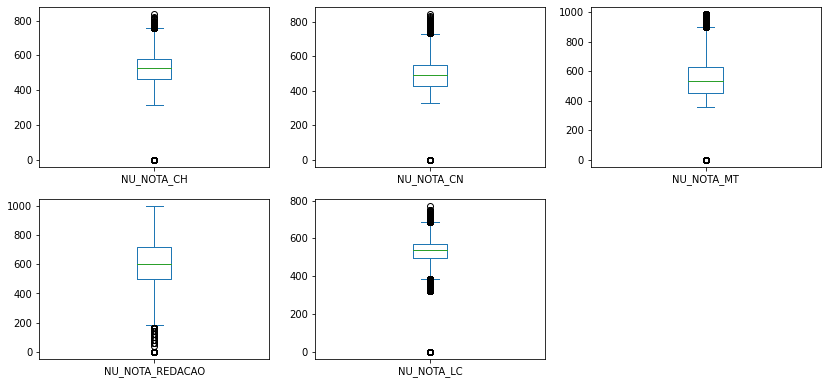

In [ ]:
df_dados4[notas].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

## Aplicar a função que irá remover valores acima e abaixo determinados limites definidos pelo IQR
- IQR - Interquartile range

In [ ]:
df_CH = remove_outlier(df_dados4, 'NU_NOTA_CH')
#
total_df = df_dados4.shape[0]
total_CH = df_CH.shape[0]
removidas = total_df - total_CH
print("Total linhas df:", total_df)
print("Total linhas apos remover outliers:", total_CH)
print('Total linhas removidas:', removidas)
print("Percentual removido de linhas")
percentual = str(round(100*(removidas/total_df),2))+'%'
print(percentual)

Total linhas df: 411945
Total linhas apos remover outliers: 410479
Total linhas removidas: 1466
Percentual removido de linhas
0.36%


In [ ]:
df_CN = remove_outlier(df_CH, 'NU_NOTA_CN')
#
total_df = df_CH.shape[0]
total_CN = df_CN.shape[0]
removidas = total_df - total_CN
print("Total linhas df:", total_df)
print("Total linhas apos remover outliers:", total_CN)
print('Total linhas removidas:', removidas)
print("Percentual removido de linhas")
percentual = str(round(100*(removidas/total_df),2))+'%'
print(percentual)


Total linhas df: 410479
Total linhas apos remover outliers: 389358
Total linhas removidas: 21121
Percentual removido de linhas
5.15%


In [ ]:
df_MT = remove_outlier(df_CN, 'NU_NOTA_MT')
#
total_df = df_CN.shape[0]
total_MT = df_MT.shape[0]
removidas = total_df - total_MT
print("Total linhas df:", total_df)
print("Total linhas apos remover outliers:", total_MT)
print('Total linhas removidas:', removidas)
print("Percentual removido de linhas")
percentual = str(round(100*(removidas/total_df),2))+'%'
print(percentual)

Total linhas df: 389358
Total linhas apos remover outliers: 388859
Total linhas removidas: 499
Percentual removido de linhas
0.13%


In [ ]:
df_REDACAO = remove_outlier(df_MT, 'NU_NOTA_REDACAO')
#
total_df = df_MT.shape[0]
total_REDACAO = df_REDACAO.shape[0]
removidas = total_df - total_REDACAO
print("Total linhas df:", total_df)
print("Total linhas apos remover outliers:", total_REDACAO)
print('Total linhas removidas:', removidas)
print("Percentual removido de linhas")
percentual = str(round(100*(removidas/total_df),2))+'%'
print(percentual)

Total linhas df: 388859
Total linhas apos remover outliers: 380579
Total linhas removidas: 8280
Percentual removido de linhas
2.13%


In [ ]:
df_LC = remove_outlier(df_REDACAO, 'NU_NOTA_LC')
#
total_df = df_REDACAO.shape[0]
total_LC = df_LC.shape[0]
removidas = total_df - total_LC
print("Total linhas df:", total_df)
print("Total linhas apos remover outliers:", total_LC)
print('Total linhas removidas:', removidas)
print("Percentual removido de linhas")
percentual = str(round(100*(removidas/total_df),2))+'%'
print(percentual)

Total linhas df: 380579
Total linhas apos remover outliers: 372912
Total linhas removidas: 7667
Percentual removido de linhas
2.01%


## Ao remover outliers da coluna NU_NOTA_CH, foram removidas linhas com 3 notas ausentes.

In [ ]:
df_CH.total_nan.value_counts()

0    389744
2     20735
Name: total_nan, dtype: int64

## Ao remover outliers da coluna NU_NOTA_CN, foram removidas as linhas com 2 notas ausentes. Agora o dataset possue as 5 notas de cada aluno inscrito.

In [ ]:
df_CN.total_nan.value_counts()

0    389358
Name: total_nan, dtype: int64

In [ ]:
df_LC.shape

(372912, 122)

## A função que remove outliers removeu as linhas cujas notas estavam acima ou abaixo do IQR. Restauram 372912 linhas onde todas as notas estão presentes.

In [ ]:
df_dados5= df_LC

In [ ]:
df_dados5.shape

(372912, 122)

In [ ]:
df_dados5.total_nan.value_counts()

0    372912
Name: total_nan, dtype: int64

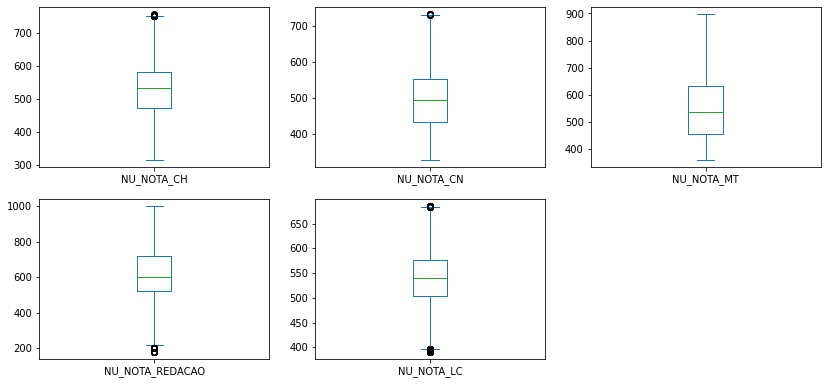

In [ ]:
df_dados5[notas].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

In [ ]:
df_dados5[notas].describe()

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
count,372912.000000,372912.000000,372912.000000,372912.000000,372912.000000
mean,527.262197,494.737302,549.879768,621.368151,537.723904
std,78.572104,76.519882,113.366251,164.055295,53.067262
min,315.900000,327.900000,359.000000,180.000000,391.200000
25%,471.900000,433.800000,455.700000,520.000000,503.900000
50%,532.900000,493.000000,536.500000,600.000000,540.400000
75%,583.900000,552.800000,633.000000,720.000000,575.400000
max,757.300000,731.800000,896.500000,1000.000000,684.800000


## Dataset df_dados6 tera as colunas de notas com os pesos atributos.
## Serão criadas novas colunas para receber notas com os respectivos pesos aplicados.

In [ ]:
df_dados6 = df_dados5
df_dados6.shape

(372912, 122)

## Notas com os respectivos pesos atribuidos
- NU_NOTA_CN peso 1
- NU_NOTA_CH peso 3
- NU_NOTA_MT_ peso 1
- NU_NOTA_REDACAO peso 3
- NU_NOTA_LC peso 2

In [ ]:
df_dados6['NU_NOTA_CN_1'] = df_dados6.NU_NOTA_CH
#
df_dados6['NU_NOTA_CH_3'] = 3*df_dados6.NU_NOTA_CH
#
df_dados6['NU_NOTA_MT_1'] = df_dados6.NU_NOTA_MT
#
df_dados6['NU_NOTA_REDACAO_3'] = 3*df_dados6.NU_NOTA_REDACAO
#
df_dados6['NU_NOTA_LC_2'] = 2*df_dados6.NU_NOTA_LC

In [ ]:
notas_peso = ['NU_INSCRICAO','NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2']

In [ ]:
df_dados6[notas_peso]

,NU_INSCRICAO,NU_NOTA_CN_1,NU_NOTA_CH_3,NU_NOTA_MT_1,NU_NOTA_REDACAO_3,NU_NOTA_LC_2
0,190001237802,575.5,1726.5,677.0,2580.0,1141.4
2,190001237804,494.1,1482.3,397.5,1800.0,959.0
3,190001237805,592.0,1776.0,695.1,1620.0,1182.2
4,190001237806,554.6,1663.8,462.4,1740.0,1039.4
7,190001237809,555.5,1666.5,729.8,2520.0,1114.0
...,...,...,...,...,...,...
534620,190005766801,528.2,1584.6,491.7,1560.0,1073.8
534621,190005766802,455.1,1365.3,463.1,1380.0,1085.2
534622,190005766803,601.2,1803.6,712.4,2520.0,1189.6
534624,190005766805,476.4,1429.2,545.5,2100.0,1105.8


## Nova coluna com a Media Ponderada das notas de cada aluno
#Media ponderada seria a soma das notas notas com os pesos aplicados dividido pela soma dos pesos (10).

In [ ]:
df_dados6['med_pond']= (df_dados6['NU_NOTA_CN_1'] +  df_dados6['NU_NOTA_CH_3'] + df_dados6['NU_NOTA_MT_1'] + df_dados6['NU_NOTA_REDACAO_3'] + df_dados6['NU_NOTA_LC_2'])/10


In [ ]:
df_dados6[['NU_INSCRICAO','NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2', 'med_pond']]

,NU_INSCRICAO,NU_NOTA_CN_1,NU_NOTA_CH_3,NU_NOTA_MT_1,NU_NOTA_REDACAO_3,NU_NOTA_LC_2,med_pond
0,190001237802,575.5,1726.5,677.0,2580.0,1141.4,670.04
2,190001237804,494.1,1482.3,397.5,1800.0,959.0,513.29
3,190001237805,592.0,1776.0,695.1,1620.0,1182.2,586.53
4,190001237806,554.6,1663.8,462.4,1740.0,1039.4,546.02
7,190001237809,555.5,1666.5,729.8,2520.0,1114.0,658.58
...,...,...,...,...,...,...,...
534620,190005766801,528.2,1584.6,491.7,1560.0,1073.8,523.83
534621,190005766802,455.1,1365.3,463.1,1380.0,1085.2,474.87
534622,190005766803,601.2,1803.6,712.4,2520.0,1189.6,682.68
534624,190005766805,476.4,1429.2,545.5,2100.0,1105.8,565.69


## Remover colunas criadas e não necessarias no modelo.
## Colunas: 
- 'NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2'
-  total_nan

In [ ]:
# Coluna NU_INSCRICAO na lista notas_peso
notas_peso.remove( 'NU_INSCRICAO')
#
df_dados7 = df_dados6.drop(columns = list(notas_peso))
df_dados7 = df_dados7.drop(columns = ['total_nan'])
df_dados7.shape

(372912, 122)

In [ ]:
df_dados7.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       ...
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'med_pond'],
      dtype='object', length=122)

In [ ]:
df_dados7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372912 entries, 0 to 534626
Columns: 122 entries, NU_INSCRICAO to med_pond
dtypes: float64(20), int64(64), object(38)
memory usage: 349.9+ MB


## Identificar variaveis tipo 'object'

In [ ]:
df_object = df_dados7.select_dtypes('object')

In [ ]:
df_object

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,NO_MUNICIPIO_NASCIMENTO,SG_UF_NASCIMENTO,NO_MUNICIPIO_PROVA,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,Contagem,MG,F,Contagem,MG,Contagem,EEBEDEEEEEBDCEEBEEEEABEEBEEBAEDEECECCDBCECEAE,EEDCCEDDBCBEABAAABADCEDABDBBCBDCCCCDAEDEDBDCB,ABBBE99999ABBCACCCAEEEDCCDADCCAEDEDDEEDBBDECBD...,CDEEEEEAEECBABABCDCACEEEEEEDEEACEAEDEBEEECEDE,...,B,A,A,B,A,A,C,B,B,B
2,Esmeraldas,MG,M,NaN,NaN,Esmeraldas,BDCBDBDECCCBDBBDDCEBBCDDBBDEDDBBBBBCDCDDCBBAC,CECCCCACABBAAABAECEEDCDACCBABCCAACDECBDDBBDEB,BCBAD99999BBBBCCEBCBBEDDAADDACCBABBBBCECADECCA...,ECBEBDDCCDDDBBDBBBEDBBDAABCEDCBCBCCBCADCBCCAB,...,A,A,A,B,A,B,C,A,A,A
3,Conselheiro Lafaiete,MG,F,Conselheiro Lafaiete,MG,Conselheiro Lafaiete,ABCABEDBCCCCAECACEBDCACDBCCBABAEDAEDBBDDDAAAE,ACBCEEACABAEACBDBCCABEABAEBADCACADCDCEDBBBEAB,BBBAD99999BBCBCDBDEBBAADCDDDDECEDBAEBCCACDCBCA...,DCEBAECCADCACEEECEACADAAEEBDAEBDAAADCEDDBEDEC,...,B,A,B,C,B,A,E,A,B,B
4,São Joaquim de Bicas,MG,F,Contagem,MG,São Joaquim de Bicas,BAEABEDBCDBAECDACBAEDBDEDBBABADEEECCCAACDDAEE,ABCAADBDCECECCBAECBBBABCAEBEDBBCBBAACEBAECBBB,CAEED99999ACABCEDEDECDDCDCDAADDDCBBAEDBEECBDED...,BAEEADEBDDCCDCCBDDCBCCEDADADABADAAACDECCAEEDB,...,B,A,A,B,B,A,C,A,B,B
7,Salinas,MG,M,Salinas,MG,Salinas,DBEAADBCEBDBEADACDBDACAAEDABAACBCCDEECACDAAAB,BEBBAAAEEBACACAEEDCECECBEADAEEBBAAEDADBEEDBDB,BADAE99999BCEABEDCACEEAECBEEDCDCACADEBDAEDDEAC...,CABEABAADDABAECBEDBDEECCDDCAACADECEDCDABCEEAD,...,A,A,A,B,A,A,E,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,Contagem,MG,M,Contagem,MG,Belo Horizonte,CEBCABCEEABEBDDCADAEBBCEEEAEDEEADDECCABDCAEBB,ABCAACBDBEAEBCABADAEBEBAAADBEAEEBBEBCEBAACEDB,BCCCD99999CEAEEEABAECEDCEECBECBBEDEAADDBECBCEA...,DBDAADEBBEACDEBCBECAADCAEDABEEABCDEEAACBEDBAC,...,B,A,A,B,B,A,D,A,B,A
534621,Uberlândia,MG,F,Uberlândia,MG,Uberlândia,CBEDEDABEEBCEDDEDBCEEACEDBAADDBCCDABCDAECCCAD,AECEABDDCBABCCDEABCADECCCDBAADDADDEECEABDDCAB,EDBAB99999BDCADABCEBBAEDBEEABECEDBEBBDDECDCEAC...,AECACCABBECDDBCCCDAAADDACECBBACDCAAEDCCEBBACC,...,B,A,A,B,B,A,B,A,A,B
534622,Vespasiano,MG,M,Belo Horizonte,MG,Vespasiano,BDCCAECEEBDAEDDABEAEDECDDBCBBABACCAEACBBBCDDE,ECBCABAACBECACECEADECBCCEDBCCAEBAEDDADBDEACDB,BDABE99999BEBEACDDECDAAECAEDADDCBCCAEBAAADEBDC...,CACECEAADEBBADCBDDBACEABCEEAECBCAEDBCDABECADE,...,B,A,A,C,A,B,D,A,B,B
534624,São João del Rei,MG,M,São João del Rei,MG,São João del Rei,DADDBBCCEBAECBABACEEACCDBEABBEDDABDCAEEBCADDB,ACADCDBEEABCBDAECCBDDAEAACBEACDACACDEBDBAECCD,ADBBE99999CCEDBCCEAECDDBDAAAEDBAECCEBBDABECCAD...,ADDAEBBCEADBADDBAEDACCBEEBCBEACDAACBEBAEECDAB,...,B,A,B,C,B,B,C,B,B,B


In [ ]:
missing_values_table(df_object)

Seu dataframe tem 38 colunas.
Há 2 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
NO_MUNICIPIO_NASCIMENTO,10870,2.9
SG_UF_NASCIMENTO,10870,2.9


In [ ]:
df_object.fillna(df_object.mode().iloc[0], inplace=True)

## Identificar as variaveis tipo object e quantidade de valores únicos

In [ ]:
colunas_obj = df_object.columns

In [ ]:
print("Coluna e quantidade de itens diferentes\n")
for col in colunas_obj:
    teste = list(df_object[col].value_counts())
    size = len(teste)
    print(col, ':',size)

Coluna e quantidade de itens diferentes

NO_MUNICIPIO_RESIDENCIA : 1292
SG_UF_RESIDENCIA : 26
TP_SEXO : 2
NO_MUNICIPIO_NASCIMENTO : 2713
SG_UF_NASCIMENTO : 27
NO_MUNICIPIO_PROVA : 188
TX_RESPOSTAS_CN : 372806
TX_RESPOSTAS_CH : 372856
TX_RESPOSTAS_LC : 372900
TX_RESPOSTAS_MT : 372837
TX_GABARITO_CN : 6
TX_GABARITO_CH : 4
TX_GABARITO_LC : 4
TX_GABARITO_MT : 7
Q001 : 8
Q002 : 8
Q003 : 6
Q004 : 6
Q006 : 17
Q007 : 4
Q008 : 5
Q009 : 5
Q010 : 5
Q011 : 5
Q012 : 5
Q013 : 5
Q014 : 5
Q015 : 5
Q016 : 5
Q017 : 5
Q018 : 2
Q019 : 5
Q020 : 2
Q021 : 2
Q022 : 5
Q023 : 2
Q024 : 5
Q025 : 2


## Analisando os dados representados pelas variaveis, foi decidido remover algumas variaveis.
## Estas variaveis nao apresentam informacao que não será util no treinamento do modelo.

In [ ]:
cols = ['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA', 
       'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO', 'NO_MUNICIPIO_PROVA',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC',
       'TX_GABARITO_MT']

## Variaveis com muitos valores únicos não uteis para o treinamento do modelo.
## Pois o objetivo é encontrar padrões de comportamentos dos dados.

In [ ]:
df_object.drop(columns = list(cols), inplace=True)
df_object.shape

(372912, 25)

In [ ]:
df_object

,TP_SEXO,Q001,Q002,Q003,Q004,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,F,E,E,C,C,G,A,C,D,B,...,B,A,A,B,A,A,C,B,B,B
2,M,H,H,F,F,B,A,B,C,A,...,A,A,A,B,A,B,C,A,A,A
3,F,E,C,C,B,G,A,B,D,B,...,B,A,B,C,B,A,E,A,B,B
4,F,B,B,C,B,C,A,B,C,B,...,B,A,A,B,B,A,C,A,B,B
7,M,A,E,B,B,C,A,B,D,A,...,A,A,A,B,A,A,E,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,M,B,B,B,B,C,A,B,C,A,...,B,A,A,B,B,A,D,A,B,A
534621,F,F,F,F,F,D,A,B,C,B,...,B,A,A,B,B,A,B,A,A,B
534622,M,C,F,B,D,H,A,D,D,C,...,B,A,A,C,A,B,D,A,B,B
534624,M,F,E,D,B,G,A,C,C,B,...,B,A,B,C,B,B,C,B,B,B


## Foi criado um dataset onde as colunas foram convertidas em valores numericos.
## Dataset df_object_dummies

In [ ]:
df_object_dummies = pd.get_dummies(data=df_object)
df_object_dummies.shape

(372912, 126)

## O dataset df_object_dummies será concatenado ao dataset com valores numericos.
## Para isso será incluida a coluna NU_INSCRICAO que sera usada como chave comum entre os datasets.

In [ ]:
df_object_dummies['NU_INSCRICAO'] = df_dados7.NU_INSCRICAO

In [ ]:
df_object_dummies.head()

,TP_SEXO_F,TP_SEXO_M,Q001_A,Q001_B,Q001_C,Q001_D,Q001_E,Q001_F,Q001_G,Q001_H,...,Q023_A,Q023_B,Q024_A,Q024_B,Q024_C,Q024_D,Q024_E,Q025_A,Q025_B,NU_INSCRICAO
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,190001237802
2,0,1,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,190001237804
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,190001237805
4,1,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,190001237806
7,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,190001237809


## Identificar as variaveis tipo numericas

In [ ]:
df_number = df_dados7.select_dtypes('number')

In [ ]:
df_number.shape

(372912, 84)

In [ ]:
df_number.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA',
       'NU_IDADE', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_IDOSO', 'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24',
       'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO',
       'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL',
       'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
       'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO',
       'IN_CADEIRA_ACOLCHOADA', 'IN_MOBILIARIO_OBESO', 'IN_L

## Identificar no dataset colunas com dados ausentes

In [ ]:
missing_values_table(df_number)

Seu dataframe tem 84 colunas.
Há 4 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
TP_ENSINO,169428,45.4
CO_MUNICIPIO_NASCIMENTO,10870,2.9
CO_UF_NASCIMENTO,10870,2.9
NU_IDADE,6,0.0


## A variavel TP_ENSINO apresenta como mais frequente o valor 1.0
## A estrategia adotada foi imputar pelo valor mais frequente nessa variavel.
## A mesma estrategia foi aplicada nas outras 3 variaveis.
## Como percentual de dados ausentes nessas 3 variaveis é baixo, isso não impactará no modelo gerado.

In [ ]:
df_number.TP_ENSINO.value_counts()

1.0    202435
2.0      1049
Name: TP_ENSINO, dtype: int64

## Valores ausentes serão preenchidos pelo valor mais frequente nessas colunas.

In [ ]:
df_number.fillna(df_number.mode().iloc[0], inplace=True)

## Identificar valores outliers na coluna NU_IDADE

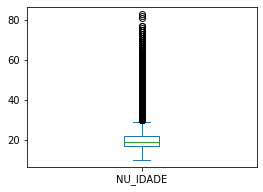

In [ ]:
df_number['NU_IDADE'].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

In [ ]:
df_number2 = remove_outlier(df_number,'NU_IDADE')

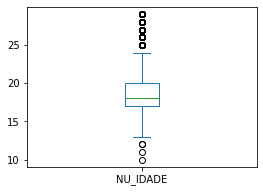

In [ ]:
df_number2['NU_IDADE'].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

## Criar 2 grupos representando as idades entre 17 e 21, que representam mais de 70% dos dados de idades.
- Grupo1 : 17 a 21
- Grupo2 : as demais idades

In [ ]:
df_number2.NU_IDADE.value_counts(normalize=True)

18.0    0.222885
17.0    0.207184
19.0    0.135266
20.0    0.088151
16.0    0.082638
21.0    0.058759
22.0    0.045197
23.0    0.034563
24.0    0.027354
25.0    0.021696
15.0    0.020656
26.0    0.017766
27.0    0.014590
28.0    0.012247
29.0    0.010350
14.0    0.000650
13.0    0.000035
12.0    0.000006
11.0    0.000003
10.0    0.000003
Name: NU_IDADE, dtype: float64

In [ ]:
temp = np.where((df_number2.NU_IDADE >= 17) & (df_number2.NU_IDADE <=21) , 1, 2 )
df_number2['GRUPO'] = temp

## Identificar as variaveis com mais de 5 valores únicos.

In [ ]:
colunas = df_number2.columns.to_list()
colunas.remove('med_pond')
colunas.remove('NU_INSCRICAO')

In [ ]:
cols = []
print("Coluna e quantidade de itens diferentes\n")
for col in colunas:
    teste = list(df_number2[col].value_counts())
    size = len(teste)
    print(col, ':',size)
    if (size > 5) or (size == 1):
      cols.append(col)
print("\nTotal de colunas com mais de 5 valores unicos:", len(cols)) 

Coluna e quantidade de itens diferentes

CO_MUNICIPIO_RESIDENCIA : 1276
CO_UF_RESIDENCIA : 26
NU_IDADE : 20
TP_ESTADO_CIVIL : 5
TP_COR_RACA : 6
TP_NACIONALIDADE : 5
CO_MUNICIPIO_NASCIMENTO : 2557
CO_UF_NASCIMENTO : 27
TP_ST_CONCLUSAO : 4
TP_ANO_CONCLUIU : 14
TP_ESCOLA : 3
TP_ENSINO : 2
IN_TREINEIRO : 2
IN_BAIXA_VISAO : 2
IN_CEGUEIRA : 2
IN_SURDEZ : 2
IN_DEFICIENCIA_AUDITIVA : 2
IN_SURDO_CEGUEIRA : 2
IN_DEFICIENCIA_FISICA : 2
IN_DEFICIENCIA_MENTAL : 2
IN_DEFICIT_ATENCAO : 2
IN_DISLEXIA : 2
IN_DISCALCULIA : 2
IN_AUTISMO : 2
IN_VISAO_MONOCULAR : 2
IN_OUTRA_DEF : 2
IN_GESTANTE : 2
IN_LACTANTE : 2
IN_IDOSO : 1
IN_SEM_RECURSO : 2
IN_BRAILLE : 2
IN_AMPLIADA_24 : 2
IN_AMPLIADA_18 : 2
IN_LEDOR : 2
IN_ACESSO : 2
IN_TRANSCRICAO : 2
IN_LIBRAS : 2
IN_TEMPO_ADICIONAL : 2
IN_LEITURA_LABIAL : 2
IN_MESA_CADEIRA_RODAS : 2
IN_MESA_CADEIRA_SEPARADA : 2
IN_APOIO_PERNA : 2
IN_COMPUTADOR : 2
IN_CADEIRA_ESPECIAL : 1
IN_CADEIRA_CANHOTO : 2
IN_CADEIRA_ACOLCHOADA : 2
IN_MOBILIARIO_OBESO : 2
IN_LAMINA_OVERLAY : 2

In [ ]:
df_number3 = df_number2.drop(columns = list(cols))
df_number3.shape

(338452, 54)

## A coluna NU_IDADE foi removida e a coluna GRUPO a substitui, representando as idades divididas em 2 grupos.
- Grupo 1: alunos entre 17 e 21 anos, grupo que representa mais de 70%
- Grupo 2: demais idades dos alunos

In [ ]:
df_number3[['med_pond',   'GRUPO']]

,med_pond,GRUPO
0,670.04,2
2,513.29,2
3,586.53,2
4,546.02,2
7,658.58,1
...,...,...
534620,523.83,1
534621,474.87,1
534622,682.68,2
534624,565.69,1


In [ ]:
df_number3.GRUPO.value_counts(normalize=True)

1    0.712246
2    0.287754
Name: GRUPO, dtype: float64

In [ ]:
df_number3

,NU_INSCRICAO,TP_ESTADO_CIVIL,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,...,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,TP_LINGUA,med_pond,GRUPO
0,190001237802,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,670.04,2
2,190001237804,1,2,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,513.29,2
3,190001237805,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,586.53,2
4,190001237806,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,546.02,2
7,190001237809,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,658.58,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,190005766801,1,1,2,2,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,523.83,1
534621,190005766802,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,474.87,1
534622,190005766803,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,682.68,2
534624,190005766805,1,1,1,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,565.69,1


## Concatenar os datasets df_object_dummies e df_number3

In [ ]:
df_number3.shape

(338452, 54)

In [ ]:
df_number3.columns

Index(['NU_INSCRICAO', 'TP_ESTADO_CIVIL', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18',
       'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
       'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS',
       'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_COMPUTADOR',
       'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_MOBILIARIO_OBESO',
       'IN_LAMINA_OVERLAY', 'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE',
       'IN_SOROBAN', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL',
       'IN_SALA_ESPECIAL', 'IN_SALA_ACOMPANHANTE', 'IN_M

In [ ]:
df_object_dummies.shape

(372912, 127)

In [ ]:
df_object_dummies.columns

Index(['TP_SEXO_F', 'TP_SEXO_M', 'Q001_A', 'Q001_B', 'Q001_C', 'Q001_D',
       'Q001_E', 'Q001_F', 'Q001_G', 'Q001_H',
       ...
       'Q023_A', 'Q023_B', 'Q024_A', 'Q024_B', 'Q024_C', 'Q024_D', 'Q024_E',
       'Q025_A', 'Q025_B', 'NU_INSCRICAO'],
      dtype='object', length=127)

In [ ]:
df_dados8 = pd.merge(df_number3, df_object_dummies, on='NU_INSCRICAO')
del df_dados8['NU_INSCRICAO']

In [ ]:
df_dados8.shape

(338452, 179)

In [ ]:
missing_values_table(df_dados8)

Seu dataframe tem 179 colunas.
Há 0 colunas que possuem valores ausentes.


,Missing Values,% of Total Values


In [ ]:
df_dados8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338452 entries, 0 to 338451
Columns: 179 entries, TP_ESTADO_CIVIL to Q025_B
dtypes: float64(2), int64(51), uint8(126)
memory usage: 180.1 MB


## Identificar a correlacao das variaveis com med_pond.

In [ ]:
correlations_data = df_dados8.corr()['med_pond'].sort_values()

## Criar um dataset com as correlacoes identificadas

In [ ]:
correlations_data.to_frame().to_csv("corr.csv")

In [ ]:
df_corr = pd.read_csv('/content/corr.csv')

In [ ]:
df_corr.columns = ['variavel', 'correlacao']

In [ ]:
df_corr

,variavel,correlacao
0,Q008_B,-0.312415
1,Q024_A,-0.298972
2,Q018_A,-0.238807
3,Q010_A,-0.230669
4,Q006_B,-0.227214
...,...,...
174,Q003_E,0.234610
175,Q018_B,0.238807
176,Q003_D,0.239651
177,Q004_D,0.241397


## Selecionar as 60 melhores variaveis segundo a correlacao com media_pond.




In [ ]:
top30= []
top30 = (df_corr.head(30)).variavel.to_list()
#
tail31 = []
tail31 = (df_corr.tail(31)).variavel.to_list()
#
top60 = []
top60 = top30 + tail31
#
print(top60)

['Q008_B', 'Q024_A', 'Q018_A', 'Q010_A', 'Q006_B', 'Q014_A', 'Q013_A', 'Q019_B', 'Q023_A', 'Q016_A', 'Q007_A', 'Q025_A', 'TP_LINGUA', 'Q021_A', 'Q001_B', 'Q003_A', 'Q006_C', 'Q002_B', 'Q004_B', 'Q004_A', 'Q022_B', 'Q009_C', 'Q002_C', 'Q017_A', 'Q003_B', 'Q020_A', 'Q022_C', 'Q012_B', 'Q001_C', 'Q001_A', 'Q006_O', 'Q006_N', 'Q019_E', 'Q006_Q', 'Q019_C', 'Q007_B', 'Q019_D', 'Q007_D', 'Q024_D', 'Q022_E', 'Q008_C', 'Q008_E', 'Q002_F', 'Q013_B', 'Q008_D', 'Q004_E', 'Q021_B', 'Q010_C', 'Q001_F', 'Q024_C', 'Q001_G', 'Q016_B', 'Q025_B', 'Q023_B', 'Q002_G', 'Q014_B', 'Q003_E', 'Q018_B', 'Q003_D', 'Q004_D', 'med_pond']


In [ ]:
df_corr.variavel.to_list()

['Q008_B',
 'Q024_A',
 'Q018_A',
 'Q010_A',
 'Q006_B',
 'Q014_A',
 'Q013_A',
 'Q019_B',
 'Q023_A',
 'Q016_A',
 'Q007_A',
 'Q025_A',
 'TP_LINGUA',
 'Q021_A',
 'Q001_B',
 'Q003_A',
 'Q006_C',
 'Q002_B',
 'Q004_B',
 'Q004_A',
 'Q022_B',
 'Q009_C',
 'Q002_C',
 'Q017_A',
 'Q003_B',
 'Q020_A',
 'Q022_C',
 'Q012_B',
 'Q001_C',
 'Q001_A',
 'Q006_A',
 'Q003_F',
 'Q002_D',
 'Q001_H',
 'Q009_B',
 'Q015_A',
 'Q002_A',
 'Q003_C',
 'Q002_H',
 'TP_NACIONALIDADE',
 'GRUPO',
 'Q019_A',
 'Q011_B',
 'TP_ESTADO_CIVIL',
 'Q006_D',
 'Q012_A',
 'Q022_A',
 'TP_SEXO_F',
 'Q008_A',
 'Q001_D',
 'Q004_C',
 'Q004_F',
 'TP_ENSINO',
 'TP_ST_CONCLUSAO',
 'IN_LEDOR',
 'Q009_A',
 'IN_DEFICIENCIA_MENTAL',
 'IN_SURDEZ',
 'IN_TRANSCRICAO',
 'IN_DEFICIENCIA_FISICA',
 'IN_ACESSO',
 'IN_BAIXA_VISAO',
 'IN_MESA_CADEIRA_RODAS',
 'IN_LIBRAS',
 'IN_AMPLIADA_18',
 'IN_LACTANTE',
 'IN_SEM_RECURSO',
 'IN_CEGUEIRA',
 'IN_MAQUINA_BRAILE',
 'IN_AMPLIADA_24',
 'IN_SOROBAN',
 'Q011_C',
 'IN_BRAILLE',
 'Q006_E',
 'IN_SURDO_CEGUEIRA',
 'I

##Selecionar as 30 varaiveis segundo a correlacao com media_pond.

In [ ]:
top15= []
top15 = (df_corr.head(15)).variavel.to_list()
#
tail16 = []
tail16 = (df_corr.tail(16)).variavel.to_list()
#
top30 = []
top30 = top15 + tail16
#
print(top30)

['Q008_B', 'Q024_A', 'Q018_A', 'Q010_A', 'Q006_B', 'Q014_A', 'Q013_A', 'Q019_B', 'Q023_A', 'Q016_A', 'Q007_A', 'Q025_A', 'TP_LINGUA', 'Q021_A', 'Q001_B', 'Q004_E', 'Q021_B', 'Q010_C', 'Q001_F', 'Q024_C', 'Q001_G', 'Q016_B', 'Q025_B', 'Q023_B', 'Q002_G', 'Q014_B', 'Q003_E', 'Q018_B', 'Q003_D', 'Q004_D', 'med_pond']


## Criar 2 datasets (df_30 e df_50).


In [ ]:
df_30 = df_dados8[top30]
df_60 = df_dados8[top60]

In [ ]:
df_30.shape

(338452, 31)

In [ ]:
df_60.shape

(338452, 61)

## Treino e Teste

## Usar as 60 melhores variaveis

In [ ]:
features_60 = df_60.drop(columns='med_pond')
targets = pd.DataFrame(df_60['med_pond'])
#
X, X_test, y, y_test = train_test_split(features_60, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(236916, 60)
(101536, 60)
(236916, 1)
(101536, 1)


## Padronização

In [ ]:
X, X_test, y, y_test = aplicar_padronizacao(X, X_test, y, y_test)

## Baseline

In [ ]:
baseline_guess = np.median(y)

print('O palpite da linha de base é uma pontuação de %0.2f' % baseline_guess)
print("Desempenho de linha de base no conjunto de testes: MAE = %0.4f" % mae(y_test, baseline_guess))

O palpite da linha de base é uma pontuação de 557.12
Desempenho de linha de base no conjunto de testes: MAE = 72.1457


## Previsao

In [ ]:
%%time
random_forest = RandomForestRegressor(random_state=60)

random_forest_mae_60 = fit_and_evaluate(random_forest)

print('Performance do Random Forest Regression nos dados de teste: MAE = %0.4f' % random_forest_mae_60)

Performance do Random Forest Regression nos dados de teste: MAE = 65.4243
CPU times: user 4min 1s, sys: 1.14 s, total: 4min 3s
Wall time: 4min 3s


In [ ]:
%%time
gradient_boosted = GradientBoostingRegressor(random_state=60)

gradient_boosted_mae_60 = fit_and_evaluate(gradient_boosted)

print('Performance doo Gradient Boosted Regression nos dados de teste: MAE = %0.4f' % gradient_boosted_mae_60)

Performance doo Gradient Boosted Regression nos dados de teste: MAE = 61.3737
CPU times: user 50.1 s, sys: 77 ms, total: 50.2 s
Wall time: 50.1 s


In [ ]:
%%time
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae_60 = fit_and_evaluate(knn)

print('Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = %0.4f' % knn_mae_60)

Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = 64.4736
CPU times: user 11min 29s, sys: 30.9 s, total: 12min
Wall time: 9min 49s


#Performance usando as melhores 60 variaveis

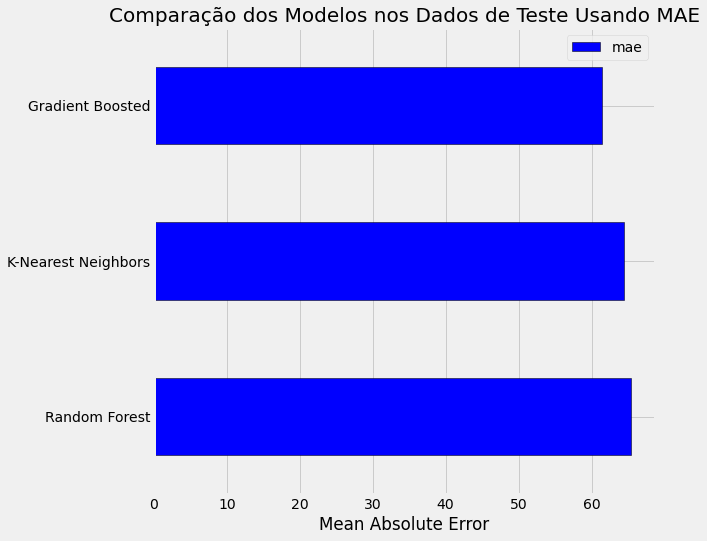

In [ ]:
plot_models(knn_mae_60, gradient_boosted_mae_60, random_forest_mae_60)

##Usar as 30 melhores variaveis

In [ ]:
features_30 = df_30.drop(columns='med_pond')
targets = pd.DataFrame(df_30['med_pond'])
#
X, X_test, y, y_test = train_test_split(features_30, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(236916, 30)
(101536, 30)
(236916, 1)
(101536, 1)


##Padronizacao

In [ ]:
X, X_test, y, y_test = aplicar_padronizacao(X, X_test, y, y_test)

##Previsao

In [ ]:
%%time
random_forest = RandomForestRegressor(random_state=60)

random_forest_mae_30 = fit_and_evaluate(random_forest)

print('Performance do Random Forest Regression nos dados de teste: MAE = %0.4f' % random_forest_mae_30)

Performance do Random Forest Regression nos dados de teste: MAE = 64.7934
CPU times: user 1min 25s, sys: 618 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
%%time
gradient_boosted = GradientBoostingRegressor(random_state=60)

gradient_boosted_mae_30 = fit_and_evaluate(gradient_boosted)

print('Performance do Gradient Boosted Regression nos dados de teste: MAE = %0.4f' % gradient_boosted_mae_30)

Performance do Gradient Boosted Regression nos dados de teste: MAE = 61.8428
CPU times: user 26.4 s, sys: 62 ms, total: 26.5 s
Wall time: 26.4 s


In [ ]:
%%time
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae_30 = fit_and_evaluate(knn)

print('Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = %0.4f' % knn_mae_30)

Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = 65.0547
CPU times: user 10min 15s, sys: 27.4 s, total: 10min 43s
Wall time: 9min 6s


#Performance usando as melhores 30 variaveis

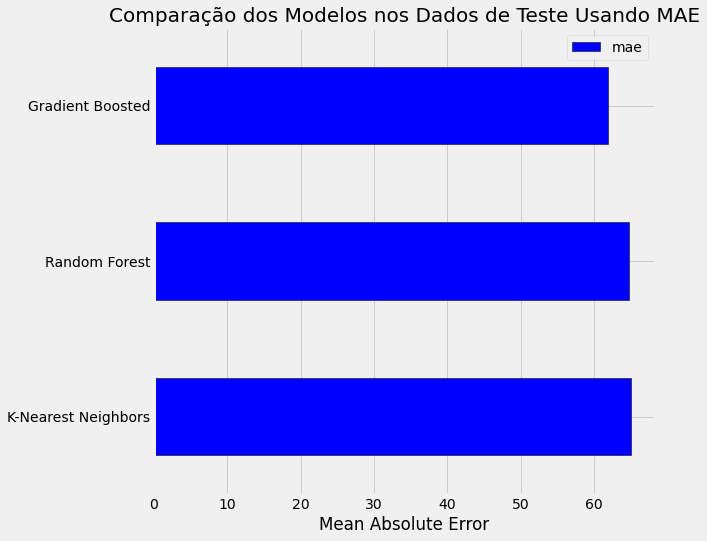

In [ ]:
plot_models(knn_mae_30, gradient_boosted_mae_30, random_forest_mae_30)

In [ ]:
total_features_30 = features_30.shape[1]
total_features_60 = features_60.shape[1]
data = {'Total_features': [total_features_30, total_features_30, total_features_30, total_features_60,total_features_60,total_features_60],
        'Modelo':['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted','K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted'],
        'Mae': [knn_mae_30,random_forest_mae_30,  gradient_boosted_mae_30, knn_mae_60,random_forest_mae_60,  gradient_boosted_mae_60] }

df_mae = pd.DataFrame(data)  

In [ ]:
df_mae.sort_values(by='Mae')

,Total_features,Modelo,Mae
5,60,Gradient Boosted,61.373688
2,30,Gradient Boosted,61.842779
3,60,K-Nearest Neighbors,64.473646
1,30,Random Forest,64.793450
0,30,K-Nearest Neighbors,65.054717
4,60,Random Forest,65.424331


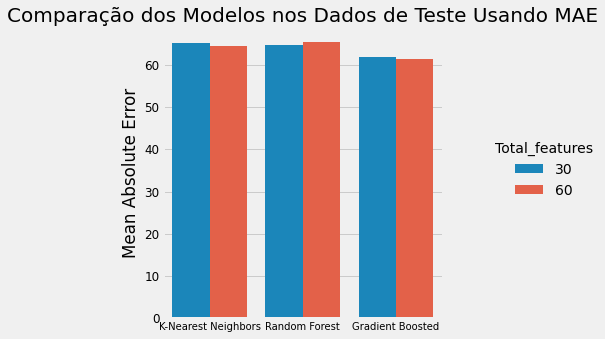

In [ ]:
plot_models2(df_mae)

## Shapey Value Feature Importance
## Identificar as 20 variaveis que mais impactam no modelo

In [ ]:
X = df_60.drop(columns='med_pond')
y = df_60['med_pond']

In [ ]:
model = GradientBoostingRegressor(random_state = 42)
#
model.fit(X,y)

GradientBoostingRegressor(random_state=42)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

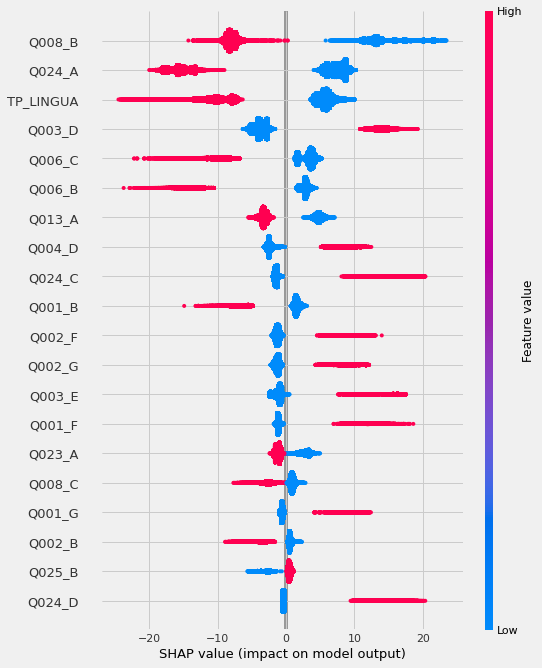

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

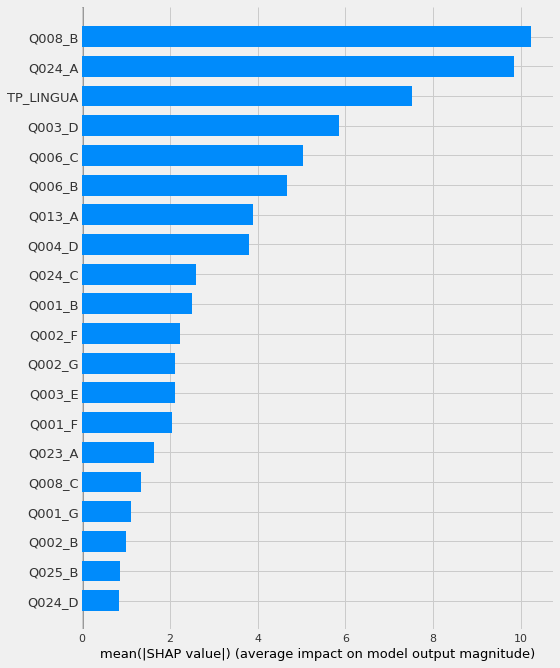

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Analise das variavel encontradas pelo Shap VAlue

# Questoes por ordem de impacto sobre o mdelo:

## Q008B
- Na sua residencia tem banheiro? : Sim,um.

##Q0024A
- Na sua residencia tem computador? : Não

## TP_LINGUA
- teste de idioma em : INGLES ou ESPANHOL

## Q003D
- grupo que indica ocupacao do pai: Grupo4 (ensino fundamental ou medio)

## Q006C
- Qual é a renda mensal da familia? faixa de R$998,01 ate R$1497,00

## Q006B
- Qual é a renda mensal da familia? faixa ate R$998,00

## Q013A
- Na sua residencia tem freezer? : Nao

## Q004D
- grupo que indica ocupacao da mae: Grupo4 (ensino fundamental ou medio)

## Q024C
- Na sua residencia tem computador? : Sim, dois

## Q001B
- Ate que serie seu pai ou responsavel, estudou? :
 Não completou a 4ª série/5º ano do Ensino Fundamental.


 ## Q002F
 -  Ate que serie sua mae ou responsavel, estudou? :
 Completou a Faculdade, mas não completou a Pós-graduação.


 ##  Q002G
 -  Ate que serie sua mae ou responsavel, estudou? :
 Completou a Pós-graduação.


 ## Q003E
 - grupo que indica ocupacao do pai: Grupo5 (ensino superior)


 ## Q001F
 - Ate que serie seu pai ou responsavel, estudou? :
 Completou a Faculdade, mas não completou a Pós-graduação.


 ## Q023A
 - Na sua residencia tem telefone fixo? : Nao


 ## Q008C
 - Na sua residencia tem banheiro? : Si, dois


 ## Q001G
 -  Ate que serie seu pai ou responsavel, estudou? :
 Completou a Pós-graduação.


 ## Q002B
  -  Ate que serie sua mae ou responsavel, estudou? :
 Não completou a 4ª série/5º ano do Ensino Fundamental.


 ## Q025B
 - Na sua residencia tem acesso a internet? : Sim


 ## Q024D
 - Na sua residencia tem computador? : Sim, tres


# Um especialista em ensino seria a melhor pessoa para extrair conclusoes a partir das variaveis apontadas como tendo maior impacto sobre a media ponderada dos alunos inscritos no enem, mas algumas observacoes podem ser feitas a partir das respostas dados para as questoes.

-  Ter computador em casa, gera um alto impacto, pois o computador pode ser fonte de consulta, de exercicios e aprimorando dos estudos apos a escola.

- O teste de linguas ser ingles ou Espanhol, gera um alto impacto pois é um conhecimento que leva um tempo ate ser assimilado e a forma de ensino precisa ser atualizada para motivar os alunos. Isso já comecou a ser feito nas escolas publicas.

- A renda da familia com certeza gera impacto pois uma renda maior pode significar que os pais podem manter os filhos apenas estudando, investir em cursos, livros e assim ter mais acesso a informacao.

- A ocupacao do pai ou do homem responsavel pelo aluno apresenta um alto impacto, talvez porque dele seja maior parcela da renda da familia. E uma renda maior ou menor influencia nas condicoes de vida e por consequencia no desempenho escolar do aluno.

- O nivel de escolaridade dos pais gera impacto sobre o modelo. Pais com maior escolaridade tendem a investir nos estudos dos filhos.
